# **Matrix Multiplication Performance Comparison: C, Python and NumPy**

- Name: Võ Trần Duy Hoàng
- Student ID: 23120266 

## 1. Introduction:
#### a. Overview of the Approaches:
I will implement and measure the performance of the same fundamental matrix multiplication algorithm (using three nested loops) across three environments:
- **Pure C** - Low-level compiled language
- **Pure Python** - High-level interpreted language with native loops
- **NumPy** - Python with optimized numerical library
  
This allows to clearly observe the performance trade-offs between compiled languages, interpreted languages, and specialized scientific computing libraries.

#### b. Timing Methodology: 
- The systematic testing framework is a Python-based framework that will be used to automate the entire process: compiling the C code, running the tests for all three implementations, and collecting the results.
- For each matrix size, I will run 5 trials and take the average execution time. 
- All timings will be measured and reported in milliseconds (ms).

#### c. Matrix Initialization: 
All matrices will be square matrices, initialized with random floating-point values between 0.0 and 1.0.

#### d. Matrix Sizes Tested: 
64x64, 128x128, 256x256, 512x512, 1024x1024, 2048x2048.

*Note: The pure Python implementation is extremely slow for large matrices. Therefore, I will only run it for smaller sizes (up to 256x256) to avoid excessively long wait times.*

## 2. Implementation Code: 

#### a. Pure C Implementation: 
C Program implements matrix multiplication using three nested loops and guarantees that dynamic memory allocation (malloc) is used. The implementation is shown clearly in matrix_mult.c  

#### b. Pure Python Implementation: 
First, let's import the necessary libraries for the framework and analysis.

In [13]:
import subprocess
import re
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

This function performs matrix multiplication using native Python lists and three nested loops.

In [2]:
def pure_python_matrix_mul(size):
    """
    Performs matrix multiplication using pure Python
    """
    
    # Initialize matrices A and B with random values
    mat_A = [[random.random() for _ in range(size)] for _ in range(size)]
    mat_B = [[random.random() for _ in range(size)] for _ in range(size)]
    
    # Initialize the result matrix with zeros
    result = [[0.0 for _ in range(size)] for _ in range(size)]

    start_time = time.time()
    
    # Three nested loops for multiplication
    for i_row in range(size):
        for i_col in range(size):
            for i in range(size):
                result[i_row][i_col] += mat_A[i_row][i] * mat_B[i][i_col]
                
    end_time = time.time()
    
    return (end_time - start_time) * 1000.0 # Return time in milliseconds

#### c. NumPy Implementation:
This function uses NumPy's @ operator for matrix multiplication.

In [3]:
def numpy_matrix_mul(size):
    """
    Performs matrix multiplication using NumPy
    """
    
    # Initialize matrices A and B using NumPy arrays
    mat_A = np.random.rand(size, size)
    mat_B = np.random.rand(size, size)
    
    start_time = time.time()
    
    # Use NumPy's optimized @ operator for matrix multiplication
    result = mat_A @ mat_B
    
    end_time = time.time()
    
    return (end_time - start_time) * 1000.0 # Return time in milliseconds

#### d. Timing Framework:
The framework manages the compilation and execution of the C code, runs the Python functions, and collects all timing data into a structured format.

Here is the framework configuration. 

In [4]:
C_SOURCE = "matrix_mult.c"
EXECUTABLE = "matrix_mult"
SIZES = [64, 128, 256, 512, 1024, 2048]
PYTHON_MAX_SIZE = 256 # Limit the max size for pure Python due to slowness, can be upgraded to get more data
NUM_TRIALS = 5

This function will compiles matrix_mul.c 

In [5]:
def compile_c_code():
    """
    Compiles the C source file using gcc with the -O3 optimization flag
    """
    
    print(f"Compiling {C_SOURCE} with the -O3 optimization flag...")
    
    command = ["gcc", "-O3", C_SOURCE, "-o", EXECUTABLE]
    
    # Run command line for compilation with structure: gcc -O3 C_SOURCE_FILENAME.c -o C_EXECUTION_FILENAME 
    subprocess.run(command, check=True, capture_output=True, text=True)
    
    print("Compilation successful.")

And this function will execute matrix_mul.c 

In [6]:
def run_c_matrix_mul(size):
    """
    Executes the compiled C program and parses the execution time
    """
    
    command = [f"./{EXECUTABLE}", str(size)]

    # Run command line for execution with structure: ./C_EXECUTION_FILENAME [MATRIX_SIZE] 
    result = subprocess.run(command, check=True, capture_output=True, text=True, timeout=600)
    
    # Parse the time from the C program's output, like "TIME_MS:123.456"
    match = re.search(r"TIME_MS:(\d+\.?\d*)", result.stdout)
    # Return the result 
    if match:
        return float(match.group(1))

This core function will run all tests for all sizes and for all implementations. All collected data will be structured with Dataframe for visualization to show the clearer insights for the execution time comparisons, accurate analysis and some other interesting findings. 

In [7]:
def run_all_tests():
    """
    Runs all tests for all implementations and returns a pandas DataFrame
    """
    compile_c_code() 
    
    results = []
    for size in SIZES:
        print(f"\nTesting size: {size}x{size}")
        
        # Run C implementation test
        c_times = [run_c_matrix_mul(size) for _ in range(NUM_TRIALS)] # Get the execution times in 5 trials 
        c_avg = np.mean([t for t in c_times if t is not None]) # Take the average 
        print(f"  C Average: {c_avg:.4f} ms")

        # Run NumPy implementation test
        numpy_times = [numpy_matrix_mul(size) for _ in range(NUM_TRIALS)] # Get the execution times in 5 trials 
        numpy_avg = np.mean(numpy_times) # Take the average  
        print(f"  NumPy Average: {numpy_avg:.4f} ms")

        # Run Pure Python implementation test (for smaller sizes)
        python_avg = None
        if size <= PYTHON_MAX_SIZE:
            python_times = [pure_python_matrix_mul(size) for _ in range(NUM_TRIALS)] # Get the execution times in 5 trials 
            python_avg = np.mean(python_times) # Take the average   
            print(f"  Pure Python Average: {python_avg:.4f} ms")
        else:
            print(f"  Pure Python: Skipped (size > {PYTHON_MAX_SIZE})")

        # Collect results for each size 
        results.append({
            "Size": size,
            "Pure C (ms)": c_avg,
            "Pure Python (ms)": python_avg,
            "NumPy (ms)": numpy_avg
        })
        
    # Clean up the compiled executable
    if os.path.exists(EXECUTABLE):
        os.remove(EXECUTABLE)

    # Return all timing data in a structured format (DataFrame)
    return pd.DataFrame(results).set_index("Size")
    #return pd.DataFrame(results)

In [8]:
# Execute the framework
timing_results = run_all_tests()

Compiling matrix_mult.c with the -O3 optimization flag...
Compilation successful.

Testing size: 64x64
  C Average: 0.1850 ms
  NumPy Average: 0.7598 ms
  Pure Python Average: 14.2521 ms

Testing size: 128x128
  C Average: 1.2234 ms
  NumPy Average: 0.0633 ms
  Pure Python Average: 108.2364 ms

Testing size: 256x256
  C Average: 11.3478 ms
  NumPy Average: 0.3132 ms
  Pure Python Average: 822.3111 ms

Testing size: 512x512
  C Average: 91.3426 ms
  NumPy Average: 1.8128 ms
  Pure Python: Skipped (size > 256)

Testing size: 1024x1024
  C Average: 763.1458 ms
  NumPy Average: 11.9962 ms
  Pure Python: Skipped (size > 256)

Testing size: 2048x2048
  C Average: 14021.2700 ms
  NumPy Average: 66.7257 ms
  Pure Python: Skipped (size > 256)


## 3. Results and Visualization:

#### a. Line plot: 

Execution time vs. matrix size for all three implementations

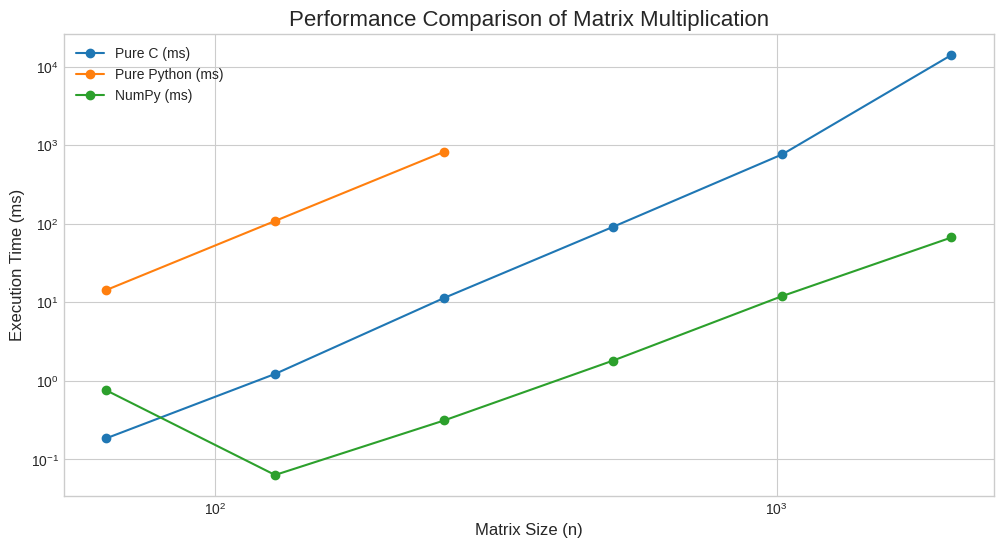

In [9]:
if timing_results is not None:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    timing_results.plot(ax=ax, marker='o', linestyle='-')

    # Configure the plot
    ax.set_title('Performance Comparison of Matrix Multiplication', fontsize=16)
    ax.set_xlabel('Matrix Size (n)', fontsize=12)
    ax.set_ylabel('Execution Time (ms)', fontsize=12)

    # Using Log-Log plot to determine whether size matters
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    plt.show()

#### b. Speedup analysis:

I create a plot showing speedup factors with **NumPy** speedup over **Pure Python** and **Pure C** speedup over **Pure Python**

In [10]:
if timing_results is not None:
    # Calculate speedup factors (only for sizes where Pure Python's data is available)
    speedup_df = timing_results[timing_results.index <= PYTHON_MAX_SIZE].copy()
    speedup_df['C Speedup vs Python'] = speedup_df['Pure Python (ms)'] / speedup_df['Pure C (ms)']
    speedup_df['NumPy Speedup vs Python'] = speedup_df['Pure Python (ms)'] / speedup_df['NumPy (ms)']
    
    display(speedup_df[['C Speedup vs Python', 'NumPy Speedup vs Python']])

,C Speedup vs Python,NumPy Speedup vs Python
Size,,
64,77.0386,18.7568
128,88.4718,1709.2485
256,72.4644,2625.6264


Moving on, I make an interesting comparison between the speedups of NumPy and C, both relative to Pure Python by using a bar plot. 

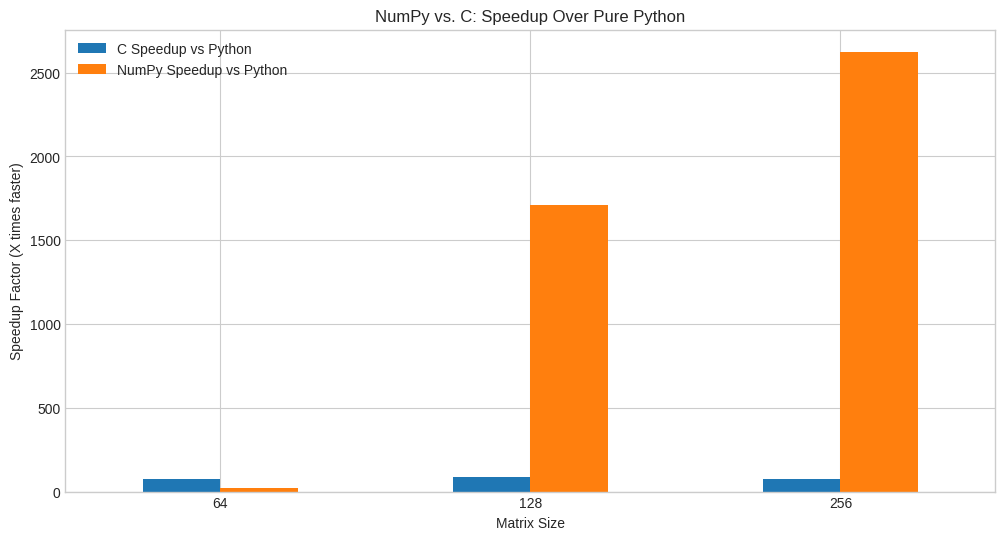

In [11]:
if speedup_df is not None:
    # Create a bar plot for visualization
    speedup_df[['C Speedup vs Python', 'NumPy Speedup vs Python']].plot(
        kind='bar',
        figsize=(12, 6),
        grid=True,
        title='NumPy vs. C: Speedup Over Pure Python',
        xlabel='Matrix Size',
        ylabel='Speedup Factor (X times faster)'
    )
    
    plt.xticks(rotation=0)
    
    plt.show()

#### c. Data table: 
The formatted table with all timing results  

In [12]:
# Display the results table
if timing_results is not None:
    display(timing_results)

,Pure C (ms),Pure Python (ms),NumPy (ms)
Size,,,
64,0.1850,14.2521,0.7598
128,1.2234,108.2364,0.0633
256,11.3478,822.3111,0.3132
512,91.3426,NaN,1.8128
1024,763.1458,NaN,11.9962
2048,14021.2700,NaN,66.7257


## 4. Analysis and Discussion: 
With evidence from the data and visualizations above, I can answer these following questions:  

#### a. Performance Ranking:

**Which is fastest? Slowest? By how much?**

- **Pure Python** is the slowest implementation. Beside that, **NumPy** and **Pure C** show no significant difference in execution time at a 64x64 size, but **NumPy** starts to outperform and becomes the fastest implementation from the 128x128 size onwards.
  
- **Pure C** provides a speedup of 70 to 90 times over **Pure Python**. In contrast, **NumPy** is only about 10 to 20 times faster at the 64x64 size, but its performance advantage grows to thousands of times for sizes of 128x128 and larger, with a clear trend of becoming even faster as the size increases.

#### b. Scaling Behavior:

**How does execution time grow? Does it match O(n³) complexity?**

- Observing this Log-Log plot, all three implementations show a nearly straight line with a slope of 3. This visually confirms that their execution time scales polynomially, consistent with the expected O(n³) complexity.

#### c. Python vs C:

**Why is Pure Python so much slower than C?**

- Unlike native languages like **C**, **Python** code gets interpreted at runtime instead of being compiled to native code at compile time. **Python** is an interpreted language, which means that the **Python** code we write must go through many, many stages of abstraction before it can become executable machine code.
  
- **C**, in contrast, is compiled directly into highly efficient machine code that runs natively on the CPU.

#### d. NumPy performance:

**Why is NumPy so much faster than Pure Python?**
- **NumPy** operations are not performed in **Pure Python**. When I call mat_A @ mat_B, **NumPy** delegates this entire operation to underlying libraries written in **C** and **Fortran**. It avoids Python's slow loops entirely, performing the computation in a highly optimized, compiled environment before returning the final result to Python.

**How does NumPy compare to C? Why?**
- **NumPy**'s performance is very close to, and can sometimes even exceed, a straightforward **Pure C** implementation compiled with optimizations.

**What optimizations does NumPy use?**
- **BLAS and LAPACK**: NumPy delegates matrix multiplication to highly optimized, low-level **Fortran** and **C** libraries called **BLAS** (Basic Linear Algebra Subprograms) and **LAPACK** (Linear Algebra Package). These libraries are fine-tuned for specific processors, providing a massive speed advantage.
  
- **Vectorization**: NumPy performs operations on entire arrays at once. Modern CPUs can also use Single Instruction, Multiple Data (SIMD) instructions to perform the same operation on multiple data elements in a single clock cycle, leading to significant parallel processing at the hardware level.

- **Cache Efficiency**: Unlike **Pure Python** lists where elements can be scattered in memory, **NumPy** arrays are stored in a single, continuous block of memory. When the computer's processor needs data, it fetches it from the slow main memory and stores a copy in a much faster, smaller memory called the cache. Because **NumPy**'s data is contiguous, when one element is fetched, its neighbors are also loaded into the cache. This means that for subsequent operations on nearby elements, the data is already in the fast cache, avoiding time-consuming access to the main memory.

#### e. Unexpected results:

**Were there any surprising findings? Explain.**
- **NumPy** can be as fast as, or even faster than, a self-written **Pure C** implementation. Because writing high-performance **Pure C** code is not just about using three nested loops; to match the performance of libraries like BLAS, a **C** programmer would need to manually implement complex optimizations for cache usage and vectorization, which is a non-trivial task.

## 5. Conclusion: 

This project clearly shows how different programming approaches affect performance.
- **Pure Python**: This is great because of its flexiblity and easy usage. However, it's not good for heavy calculations with lots of numbers. This is because **Pure Python** is an interpreted language, which means it processes code line-by-line, making it slower for intense math tasks.
  
- **Pure C**: This offers the best possible speed, showing the maximum performance. The downside is that it's more complicated. Programmers have to manage the computer's memory by hand, and the overall process of writing and running code is more complex.

- **NumPy**: This provides the best of both worlds for data science work in **Python**. It's easy to write code like in **Pure Python**, but it runs fast like **Pure C**. It achieves this by passing the heavy calculations to highly optimized, low-level code written in **C** or **Fortran**.

In short, for any work involving numbers and science, NumPy is a vital and essential tool because it's both user-friendly and very fast.